# Changing theta

This example shows how to change parameter values according to new ``Theta0``.

For example, we have run some GADMA inference for YRI, CEU data (from [Gutenkunst et al. 2009](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1000695)):

In [1]:
%%bash
cat params
rm -rf gadma_result

Input file: YRI_CEU.fs
Output directory: gadma_result
Initial structure: 2,1
Symmetric migrations: True
Silence: True


In [2]:
%%bash
gadma -p params

And we have result output:

In [4]:
%%bash
tail -n 18 gadma_result/GADMA.log 


[001:28:14]
All best by log-likelihood models
Number	log-likelihood	Model
Run 1	-1154.44	[ [ 5.0(t1), [1.602(nu11)], [Sud(dyn11)] ],	[ 1 pop split   10.23% (s1) [0.164(s1*nu11), 1.438((1-s1)*nu11)] ],	[ 1.945(t2), [2.817(nu21), 0.56(nu22)], [[0, 1.326(m2_12)], [1.326(m2_12), 0]], [Exp(dyn21), Sud(dyn22)] ] ]	m	(theta =  2072.52)

You can find picture and python code of best model in the output directory.


--Finish pipeline--


You didn't specify theta at the beginning. If you want change it and rescale parameters, please see tutorial.

Thank you for using GADMA!

In case of any questions or problems, please contact: ekaterina.e.noskova@gmail.com



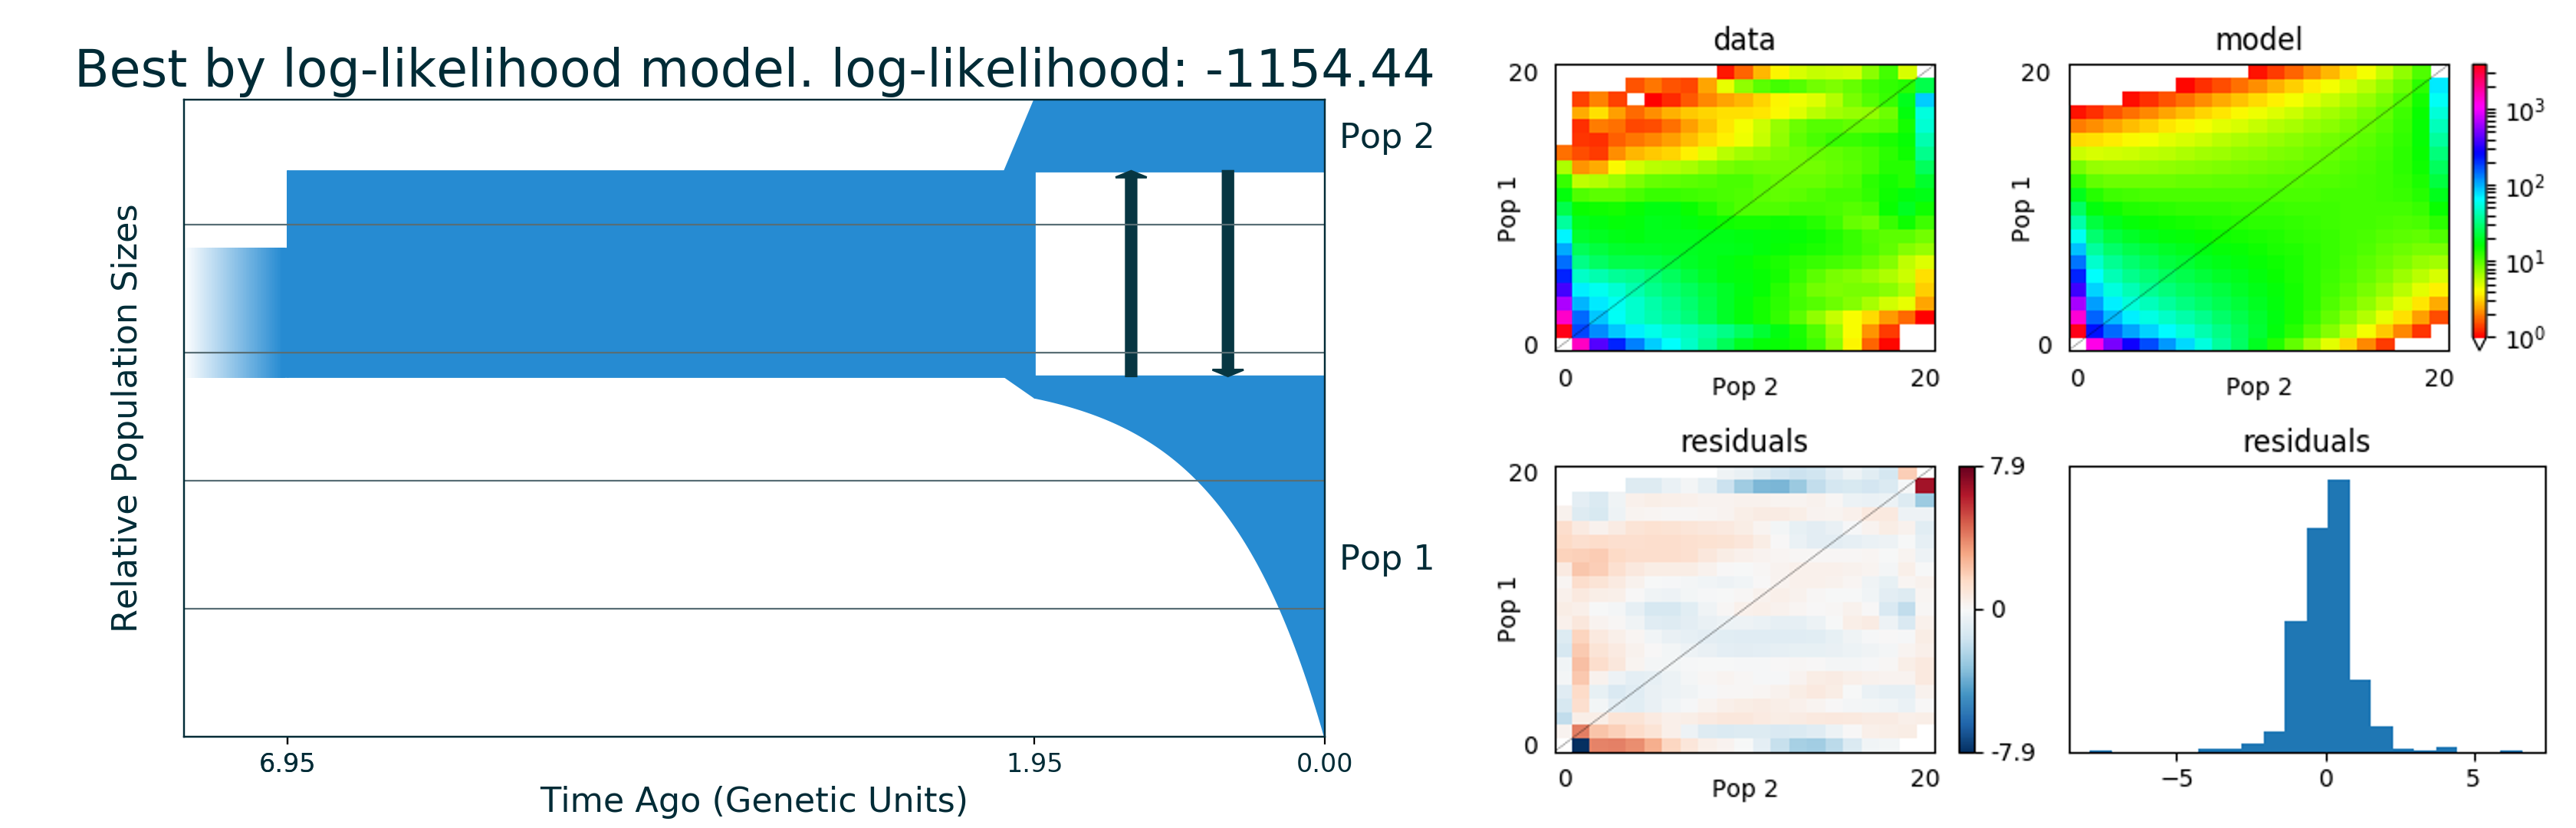

In [17]:
# Show picture of our best model
from IPython.display import Image
from IPython.core.display import HTML 

Image("gadma_result/best_logLL_model.png")

All parameters are in genetic units as we have not set ``Theta0`` and ``Relative parameters: True`` in the `params` file. So now we want to transform it. ``Theta0`` is the mutation flux that is the result of:

$\theta_0 = 4 \mu L$,

where

* $\mu$ - mutation rate per base per generation,

* $L$ - length of sequence that was used to build data.

As data is from [Gutenkunst et al. 2009](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1000695) we could take this values from the paper:

* $\mu = 2.35 \cdot 10^{-8}$

* $L = 4.04 \cdot 10^6$

Then our $\theta_0 =  4 \cdot \mu \cdot L = 4 \cdot 2.35 \cdot 10^{-8} \cdot 4.04 \cdot 10^6 = 0.37976$

### Translation

According to our log file ``GADMA.log`` we have the following parameters of the demographic  model: `t1`, `nu11`, `s1`, `t2`, `nu21`, `nu22`, `m2_12`. The genetic units are following:

* Time is in $2 \cdot N_{ref}$ generations.
* Populations sizes are relative to $N_{ref}$.
* Migrations are in $\frac{1}{2 \cdot N_{ref}}$
* Fractions of splits of populations should not be translated.

$N_{ref}$ is reference size that is usually size of ancestral population (it is so in GADMA) and could be received by:

$N_{ref} = \frac{\theta}{\theta0}$

And $\theta$ is indicated in the output of our run. So we could use the following function to translate our parameters:

In [15]:
def translate(values, par_labels, N_ref):
    new_values = list()
    for value, label in zip(values, par_labels):
        if label.lower().startswith('t'):  # Time
            new_value = 2 * N_ref * value
        elif label.lower().startswith('n'):  # Population size
            new_value = N_ref * value
        elif label.lower().startswith('m'):  # Migration
            new_value = value / (2 * N_ref)
        else:  # Fractions
            new_value = value
        new_values.append(new_value)
    return new_values

Now let us get our parameters and theta from generated code of our best model, get $N_{ref}$ and translate values:

In [11]:
%%bash
cp gadma_result/best_logLL_model_moments_code.py final_model_moments_code.py

In [20]:
from final_model_moments_code import p0, theta
par_labels = ['t1', 'nu11', 's1', 't2', 'nu21', 'nu22', 'm2_12']

print(f"Labels of our parameters:\n{par_labels}")
print(f"Values of our parameters:\n{p0}")
print(f"Optimal theta:\n{theta}")

# get N_ref
N_ref = theta / 0.37976
print(f"\nReference size:\n{int(N_ref)}")

# Translate our parameters
tr_values = translate(p0, par_labels, N_ref)
print(f"\nTranslated values of our parameters:\n{tr_values}")

# Print our parameters
print("\nSo parameters of our demographic history are:")
print(f"{par_labels[0]}\t=\t{int(tr_values[0])}\t-\t"
      "Time between ancestral population size growth/decrease and its split in generations.")
print(f"{par_labels[1]}\t=\t{int(tr_values[1])}\t-\t"
      "Size of ancestral population after growth/decrease.")
print(f"{par_labels[2]}\t=\t{tr_values[2]: .2f}\t-\t"
      "Fraction of ancestral population split. Defines initial sizes of populations after split.")
print(f"{par_labels[3]}\t=\t{int(tr_values[3])}\t-\t"
      "Time of ancestral population split in generations.")
print(f"{par_labels[4]}\t=\t{int(tr_values[4])}\t-\t"
      "Final size of population 1.")
print(f"{par_labels[5]}\t=\t{int(tr_values[5])}\t-\t"
      "Final size of population 2.")
print(f"{par_labels[6]}\t=\t{tr_values[6] : .2e}\t-\t"
      "Symmetric migration rate between population 1 and population 2.")

Labels of our parameters:
['t1', 'nu11', 's1', 't2', 'nu21', 'nu22', 'm2_12']
Values of our parameters:
[5.0, 1.6017267183354083, 0.10231452390998837, 1.9450055497773657, 2.817456387415982, 0.559720261493847, 1.3258648052909567]
Optimal theta:
2072.518176089871

Reference size:
5457

Translated values of our parameters:
[54574.42005713795, 8741.330674317765, 0.10231452390998837, 21229.5099774029, 15376.10483795062, 3054.6408665256304, 0.00012147310075881814]

So parameters of our demographic history are:
t1	=	54574	-	Time between ancestral population size growth/decrease and its split in generations.
nu11	=	8741	-	Size of ancestral population after growth/decrease.
s1	=	 0.10	-	Fraction of ancestral population split. Defines initial sizes of populations after split.
t2	=	21229	-	Time of ancestral population split in generations.
nu21	=	15376	-	Final size of population 1.
nu22	=	3054	-	Final size of population 2.
m2_12	=	 1.21e-04	-	Symmetric migration rate between population 1 and popu